# 0.0. Imports

In [5]:
import pandas as pd
import inflection
import matplotlib.pyplot as plt

import math
import numpy as np
import seaborn as sns
from matplotlib import gridspec
import datetime


from IPython.core.display import HTML
from IPython.display import Image
from IPython.display import display, HTML

from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

from scipy import stats as ss

from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error

import xgboost as xgb

import pickle

## 0.1. Helper Functions

In [6]:
def cramer_v(x,y):
        cm = pd.crosstab(x,y).as_matrix()
        n = cm.sum()
        r, k = cm.shape

        chi2 = ss.chi2_contingency(cm)[0]
        chi2corr = max(0,chi2 - (k-1)*(r-1)/(n-1))

        kcorr = k - (k-1)**2/(n-1)
        rcorr = r - (r-1)**2/(n-1)

        return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y-yhat)/y))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index = [0])

def cross_validation(x_training, kfold, model_name, model, verbose = False):

    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1, kfold+1)):
        if verbose:
            print(f'\nKFold Number: {k}')
        #start and end date for validation
        validation_start_date = x_training['date'].max() - (datetime.timedelta(days = k*6*7))
        validation_end_date = x_training['date'].max() - (datetime.timedelta(days = (k-1)*6*7))

        #filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        #training and validation dataset
        #training
        xtraining = training.drop(['date', 'sales'], axis = 1)
        ytraining = training['sales']
        #validation
        xvalidation = validation.drop(['date', 'sales'], axis = 1)
        yvalidation = validation['sales']

        #model
        m = model.fit(xtraining, ytraining)

        #prediction
        yhat = m.predict(xvalidation)

        #performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        #store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name': model_name,
                         'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)}, index=[0])


def mean_percentage_error(y, yhat):
    return np.mean((y-yhat)/y)

#enlarger cells
#resizes plots
#plt.rcParams["figure.figsize"] = (22,10)


def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [22,10]
    plt.rcParams['font.size'] = 24
    
    #display(HTML('<style>.container {width:100% !important;}</style>'))
    display(HTML(data="""
        <style>
        div#notebook-container    { width: 95%; }
        div#menubar-container     { width: 65%; }
        div#maintoolbar-container { width: 99%; }
        </style>
        """))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    sns.set()

In [7]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

In [9]:
df_sales_raw = pd.read_csv('/home/joao/projetos/dsemprod/datafiles/train.csv', low_memory = False)
df_store_raw = pd.read_csv('/home/joao/projetos/dsemprod/datafiles/store.csv', low_memory = False)

#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how = 'left', on = 'Store')

In [10]:
df_raw.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


# 1.0 Data Description

## 1.1. Rename Columns

In [11]:
df1 = df_raw.copy() #make a copy for each section of notebook

In [12]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [13]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

## 1.2. Data Dimension

In [14]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 1017209
Number of columns: 18


## 1.3. Data Types

In [15]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NaN

In [16]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NaN

In [17]:
df1['competition_distance'].max()

75860.0

In [18]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

#competition_open_since_year    
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)

#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)
               
#promo2_since_year    
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)

#promo_interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7:'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace = True)
df1['month_map'] = df1['date'].dt.month.map(month_map)

#creating is_promo column which tells if a store is in the promo or not
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)

In [19]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [20]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [21]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7. Descriptive Statistics

In [22]:
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

In [23]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T


#Dispersion - std, min, max, skewness, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

                  
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [24]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


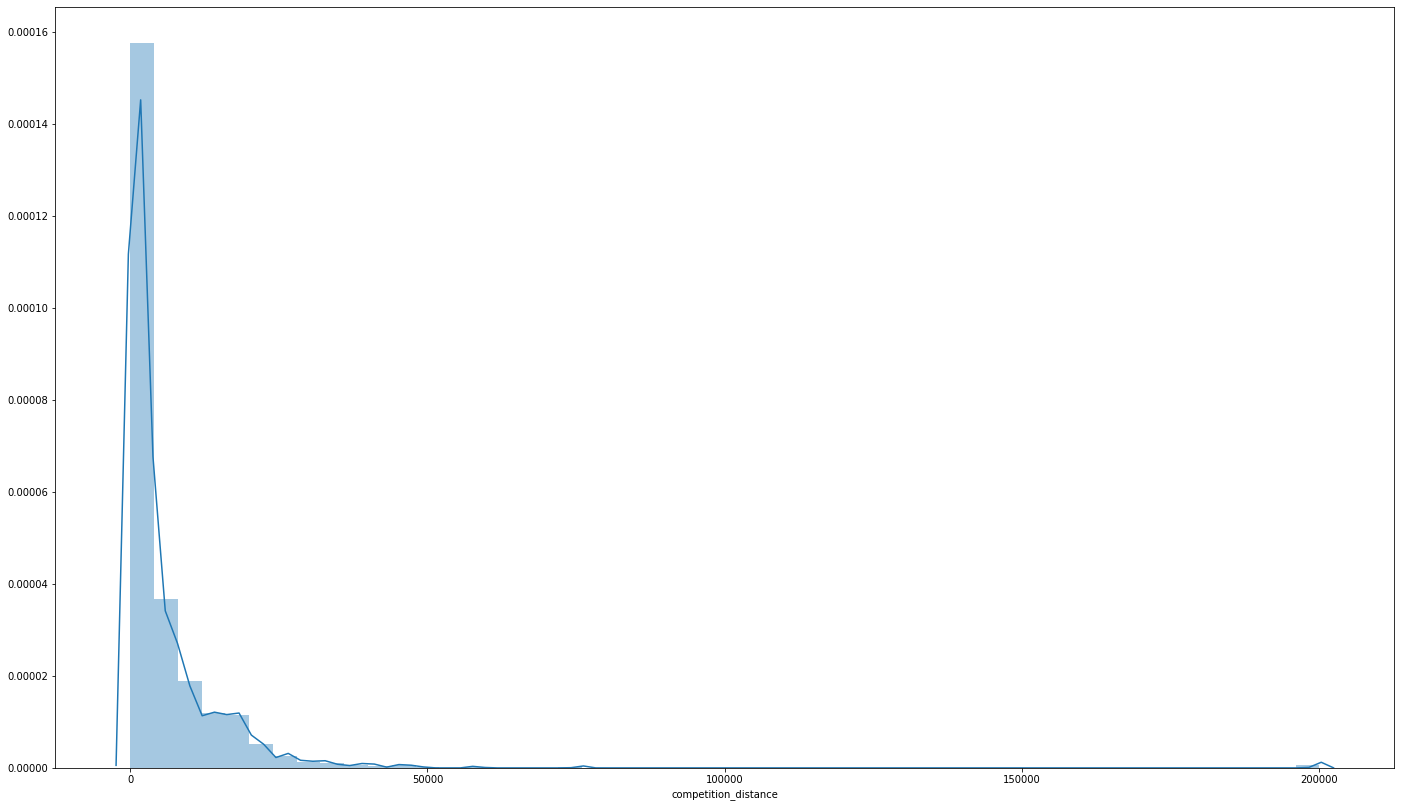

In [19]:
sns.distplot(df1['competition_distance'])

## 1.7.2. Categorical Attributes

In [20]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

In [21]:
cat_attributes['state_holiday'].unique()

array(['0', 'a', 'b', 'c'], dtype=object)

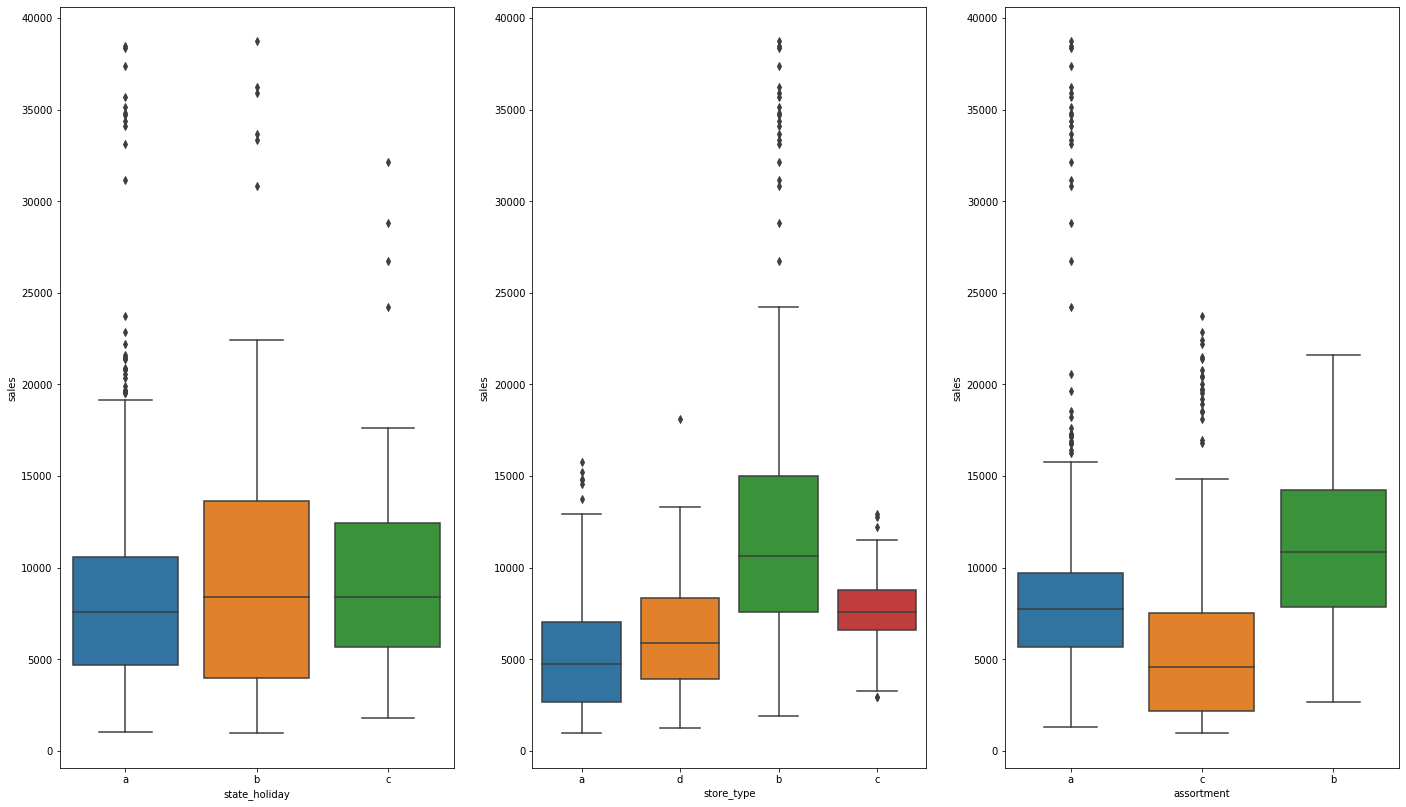

In [22]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales']>0)]

plt.subplot(1,3,1)
sns.boxplot(x = 'state_holiday', y = 'sales', data = aux1)

plt.subplot(1,3,2)
sns.boxplot(x = 'store_type', y = 'sales', data = aux1)
#assortment is the depth of products offered
plt.subplot(1,3,3)
sns.boxplot(x = 'assortment', y = 'sales', data = aux1)

# 2.0. Feature Engineering

In [25]:
df2 = df1.copy()

## 2.1. Mental Map

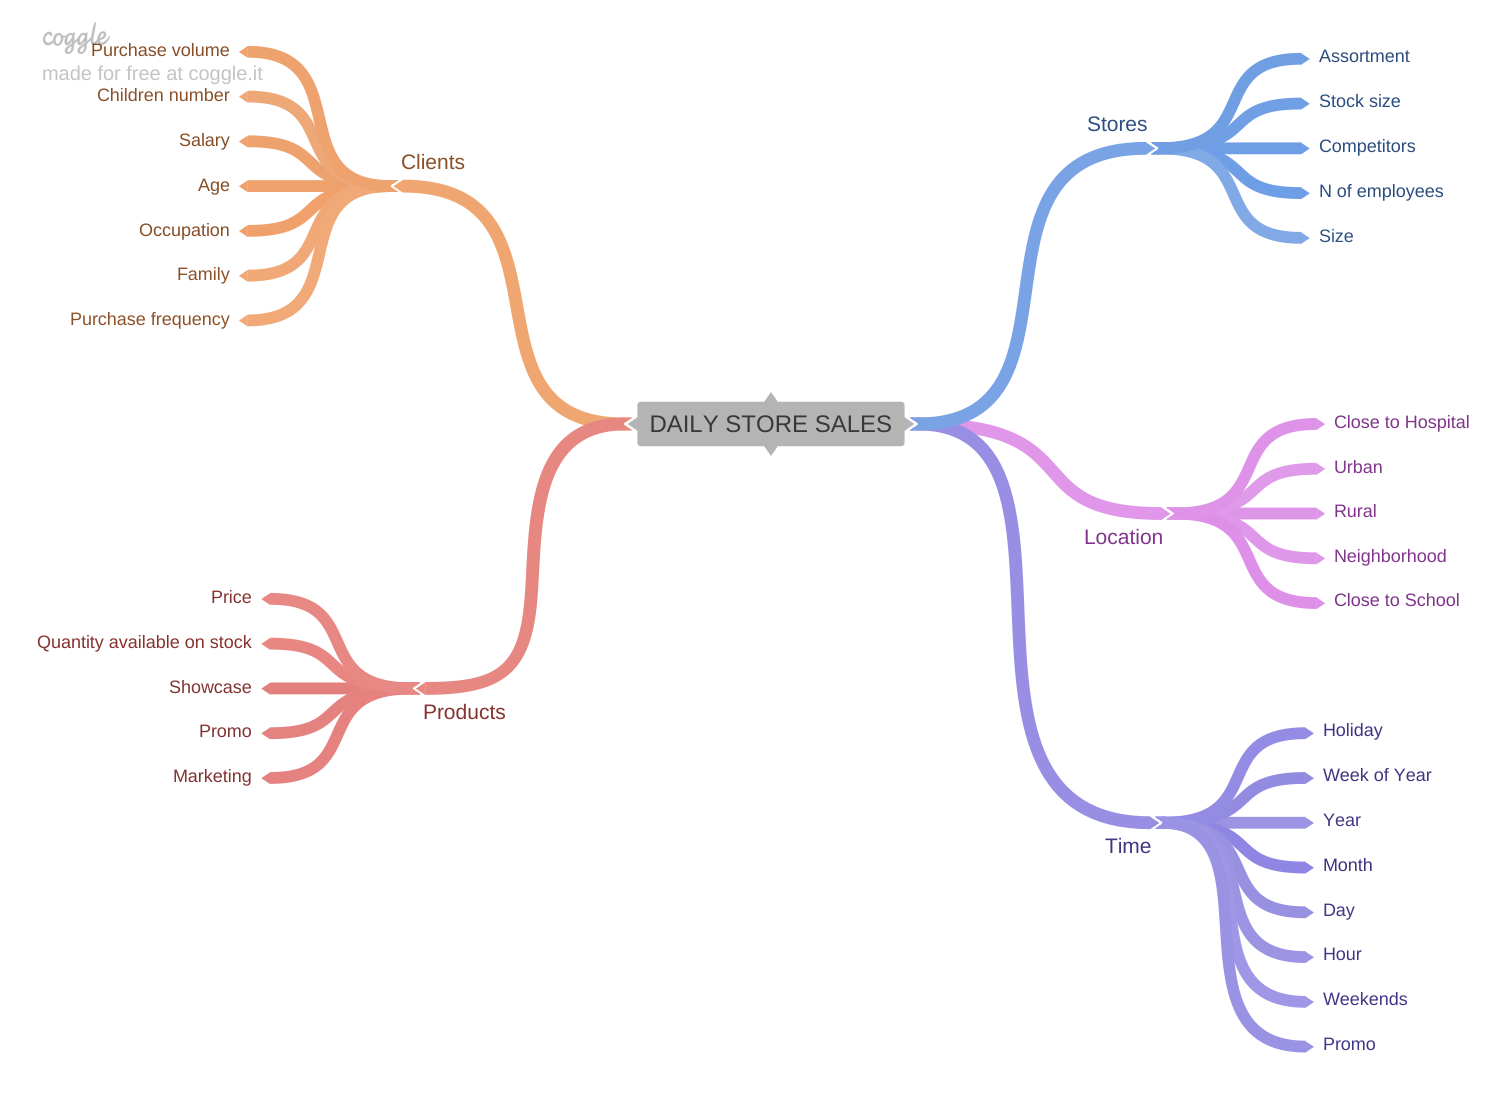

In [26]:
Image('/home/joao/projetos/dsemprod/img/mindmap_hypothesis.png')

## 2.2. Hypotheses Creation

### 2.1.1. Store Hypothesis 

**1.** Lojas com maior quadro de funcionarios deveriam vender mais.

**2.** Lojas com maior estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais

**4.** Lojas com menor porte deveriam vender menos

**5.** Lojas com maior sortimento deveriam vender mais.

**6.** Lojas com competidores mais próximos deveriam vender menos.

**7.** Lojas com competidores à mais tempo deveriam vender mais.



### 2.1.2. Product Hypothesis

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas que expõem mais os produtos nas vitrines deveriam vender mais.

**3.** Lojas que tem preços menores nos produtos deveriam vender mais.

**4.** Lojas que tem preços menores por mais tempo nos produtos deveriam vender mais.

**5.** Lojas com promoções mais agressivas (descontos maiores), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.3. Time Hypothesis

**1.** Lojas que tem mais feriados deveriam vender menos.

**2.** Lojas que abrem nos primeiros 6 meses deveriam vender mais.

**3.** Lojas que abrem nos finais de semana deveriam vender mais.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.


## 2.2. Final Hypothesis List

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos

**9.** Lojas que tem mais feriados deveriam vender menos.

**10.** Lojas deveriam vender mais no segundo semestre do ano.

**11.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**12.** Lojas deveriam vender menos aos finais de semana.

**13.** Lojas deveriam vender menos durante os feriados escolares.


## 2.3. Feature Engineering

In [27]:
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#week of the year
df2['week_of_year'] = df2['date'].dt.weekofyear

#year week format
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1), axis = 1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
#getting the data from the 1st day of the Wth week of the Yth year minus 7 days
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7))
#subtracting the time of the sale and the data the promo started to extract the number of weeks the promo has been in progress
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

#assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

#state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day') 


In [26]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. Variable Filtering

In [28]:
df3 = df2.copy()

In [28]:
df3

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,public_holiday,1,a,...,1,2013,1,1,1,2013-00,2014-06-01,-18,2013-07-29,-30
1017205,1112,2,2013-01-01,0,0,0,0,public_holiday,1,c,...,0,2013,1,1,1,2013-00,2006-04-01,82,2012-12-31,0
1017206,1113,2,2013-01-01,0,0,0,0,public_holiday,1,a,...,0,2013,1,1,1,2013-00,2013-01-01,0,2012-12-31,0
1017207,1114,2,2013-01-01,0,0,0,0,public_holiday,1,a,...,0,2013,1,1,1,2013-00,2013-01-01,0,2012-12-31,0


## 3.1. Row Filtering

In [29]:
#there are no sells when the store is closed, so we are excluding zero values 
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Column Selection

In [30]:
#the customers column is not accessible during the prediction time, so we've decided to exclude it
#some other variables have been derivated in FE part or are not needed anymore, so we're deleting them now
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis = 1)

# 4.0. Exploratory Data Analysis

In [31]:
df4 = df3.copy()

## 4.1. Univariated Analysis

### 4.1.1. Response Variable

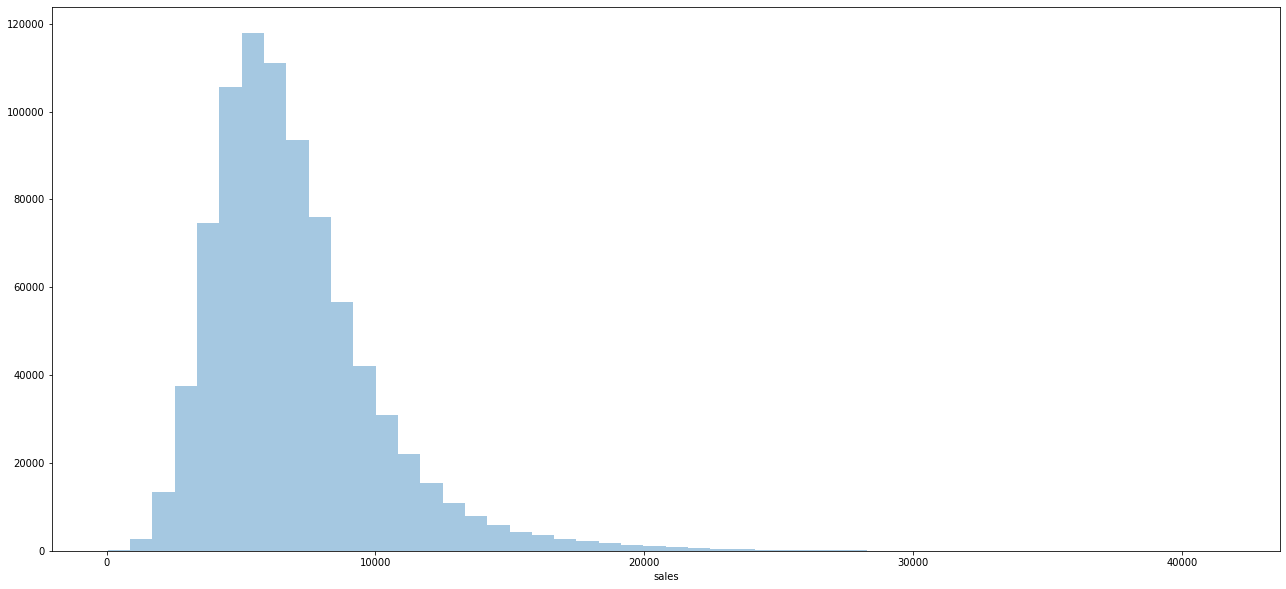

In [53]:
sns.distplot(df4['sales'], kde = False)

### 4.1.2. Numerical Variable

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff13d543bb0>,
      dtype=object)

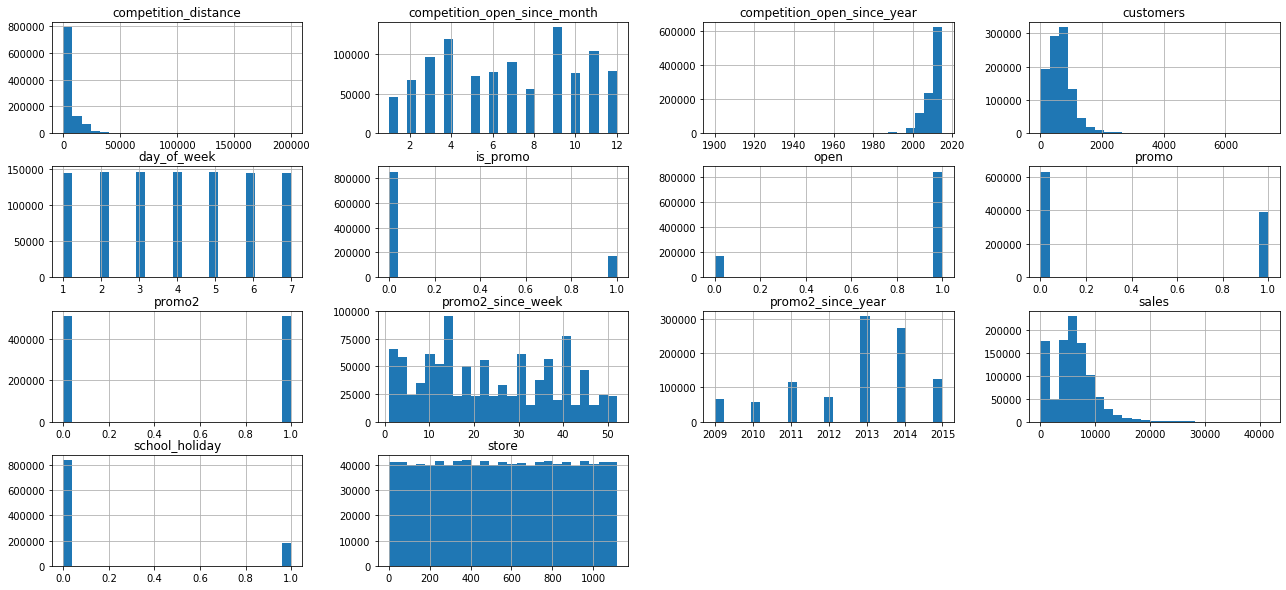

In [54]:

num_attributes.hist(bins = 25)

### 4.1.3. Categorical Variable

In [34]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [35]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

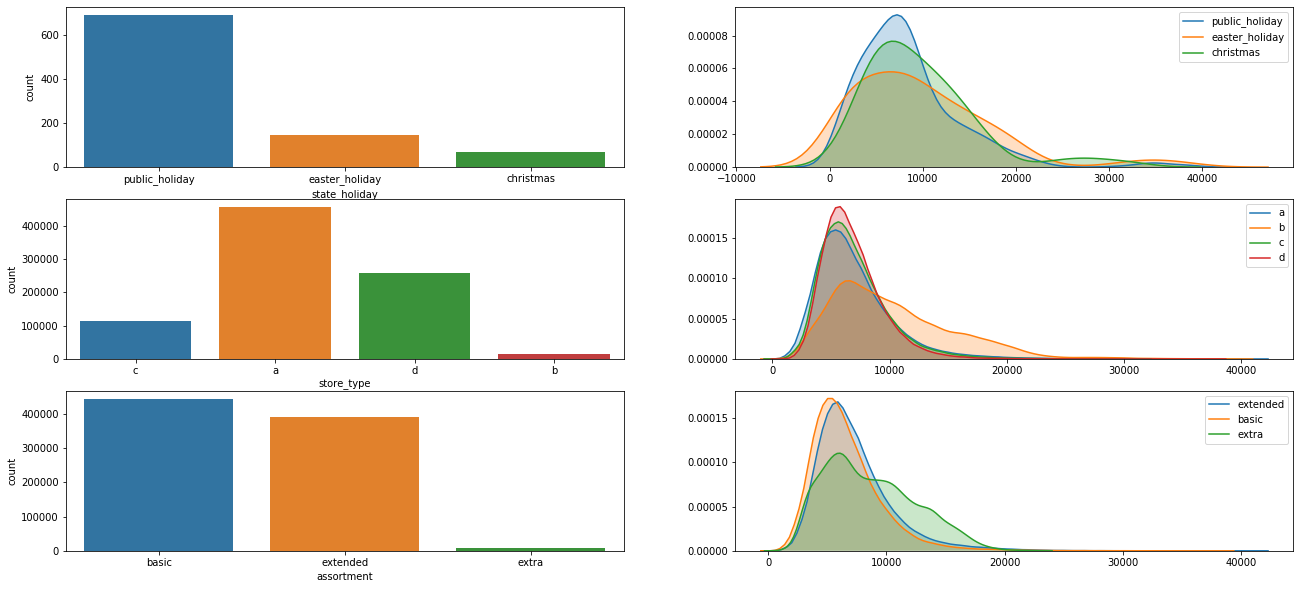

In [55]:

#state holiday
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', shade = True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', shade = True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label = 'christmas', shade = True)

#store_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd', shade = True)

#assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended', shade = True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label = 'basic', shade = True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra', shade = True)


## 4.2. Bivariated Analysis

### H1. Lojas com maior sortimento deveriam vender mais.

 ***Falso***: Vendem menos

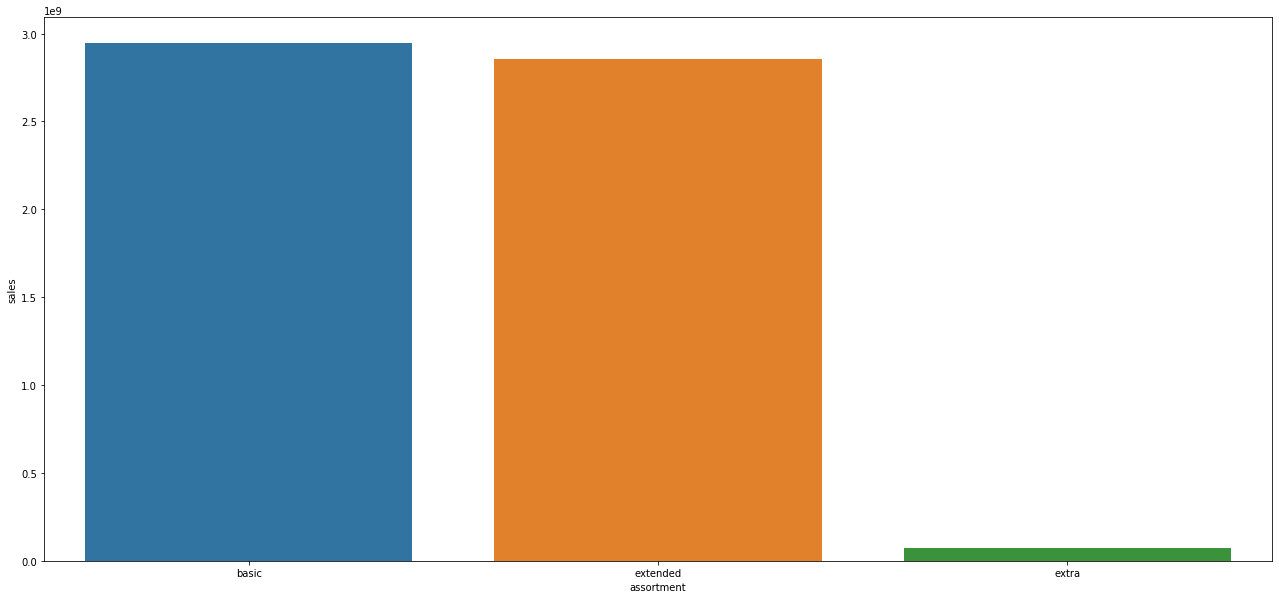

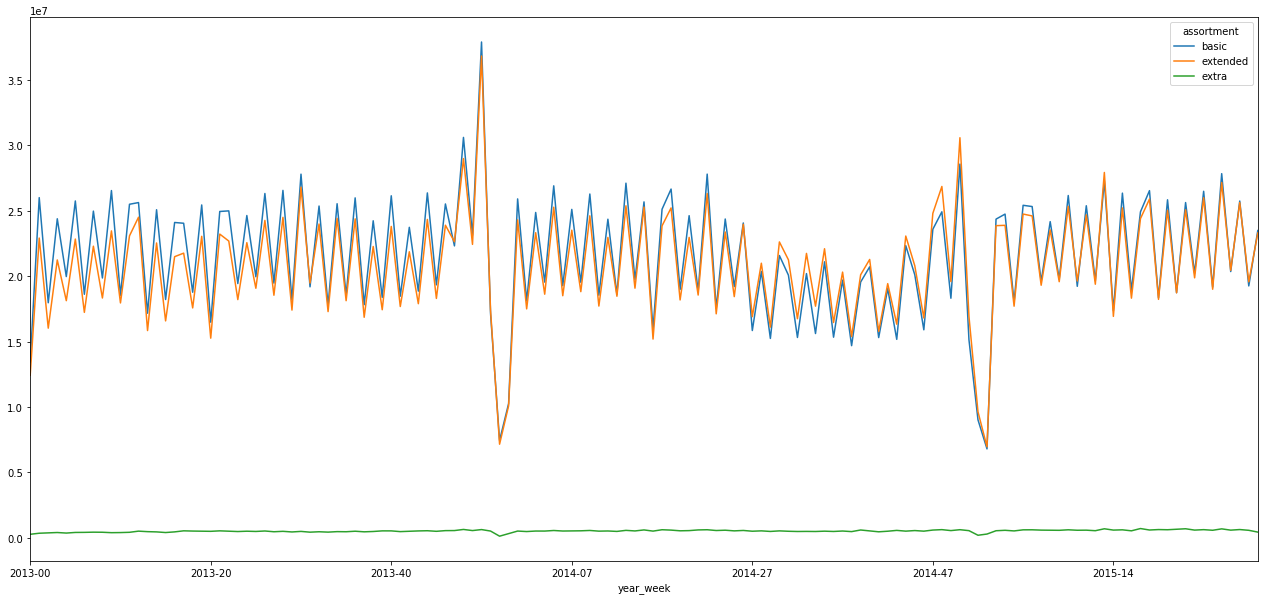

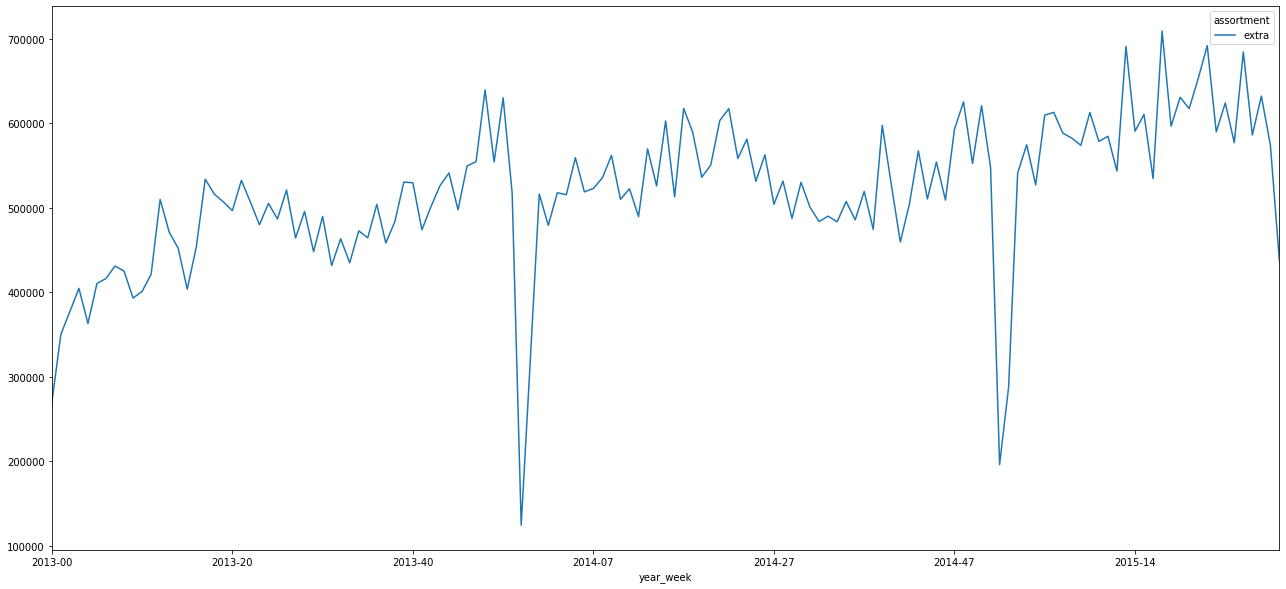

In [56]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y= 'sales', data = aux1);

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).sum().reset_index()
aux2.pivot(index = 'year_week', columns = 'assortment',  values = 'sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index = 'year_week', columns = 'assortment', values = 'sales').plot()

### H2. Lojas com competidores mais próximos deveriam vender menos.

***Falsa***: Vendem mais

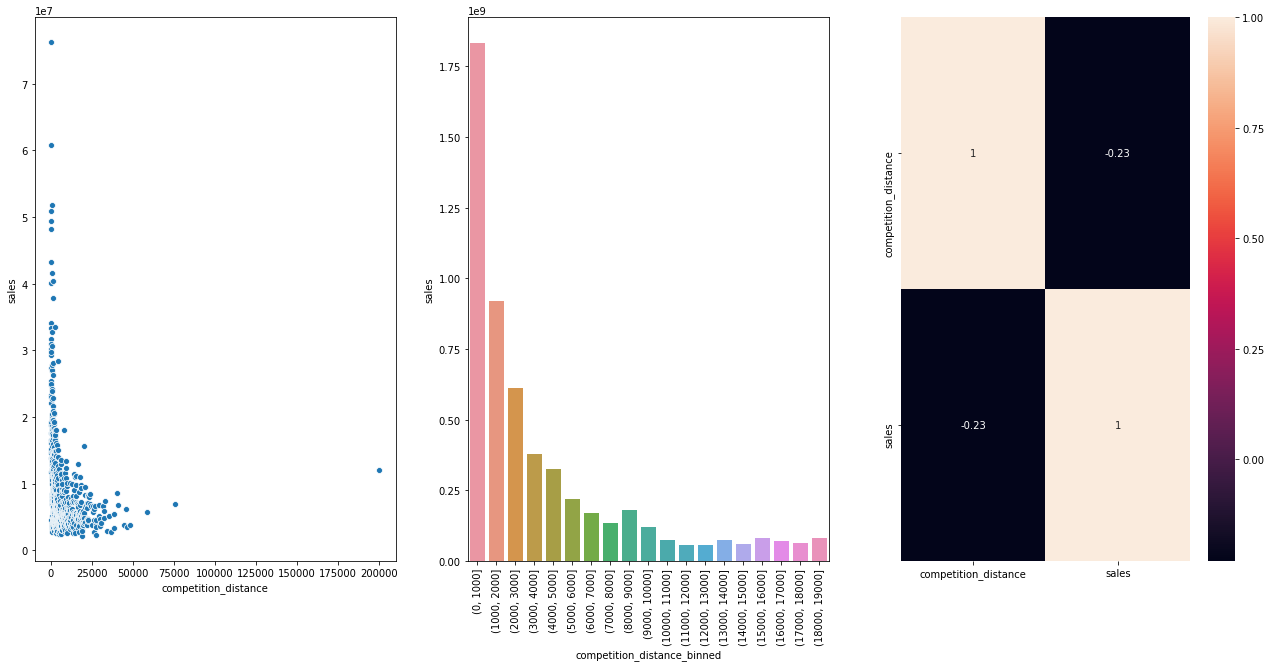

In [57]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,3,1)
sns.scatterplot(x = 'competition_distance', y= 'sales', data = aux1);


plt.subplot(1,3,2)
bins = list(np.arange(0,20000,1000)) #creates group intervals to make the plot easier to interpret
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x= 'competition_distance_binned', y = 'sales', data = aux2)
plt.xticks(rotation = 90);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### H3. Lojas com competidores à mais tempo deveriam vender mais.

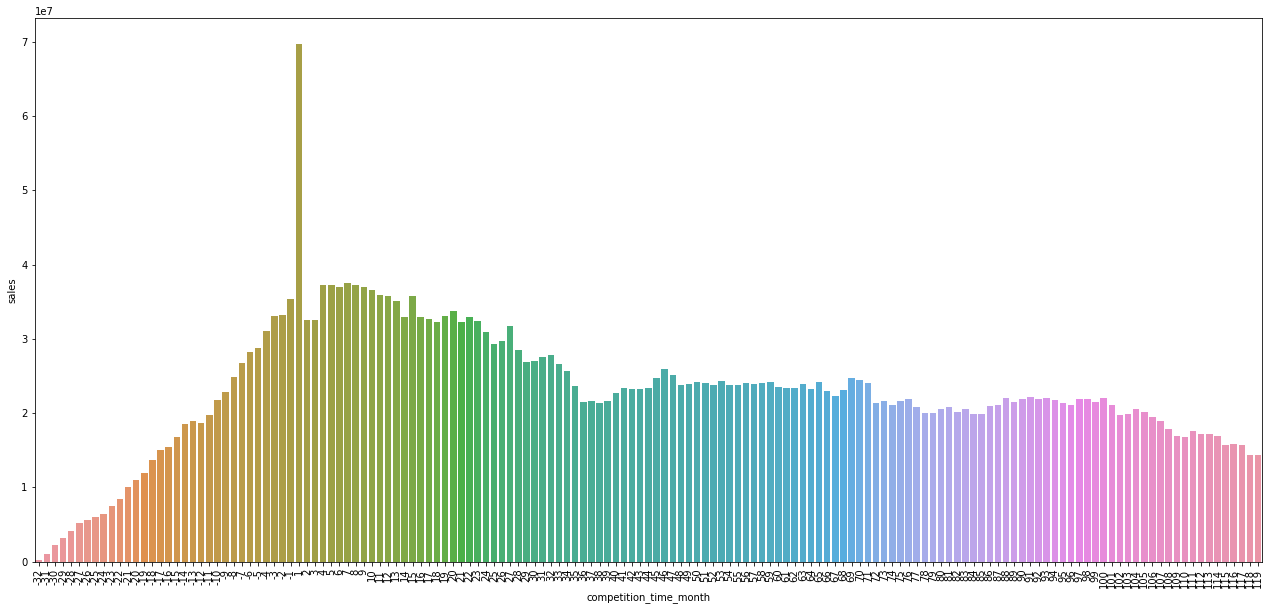

In [58]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month']<120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x = 'competition_time_month', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

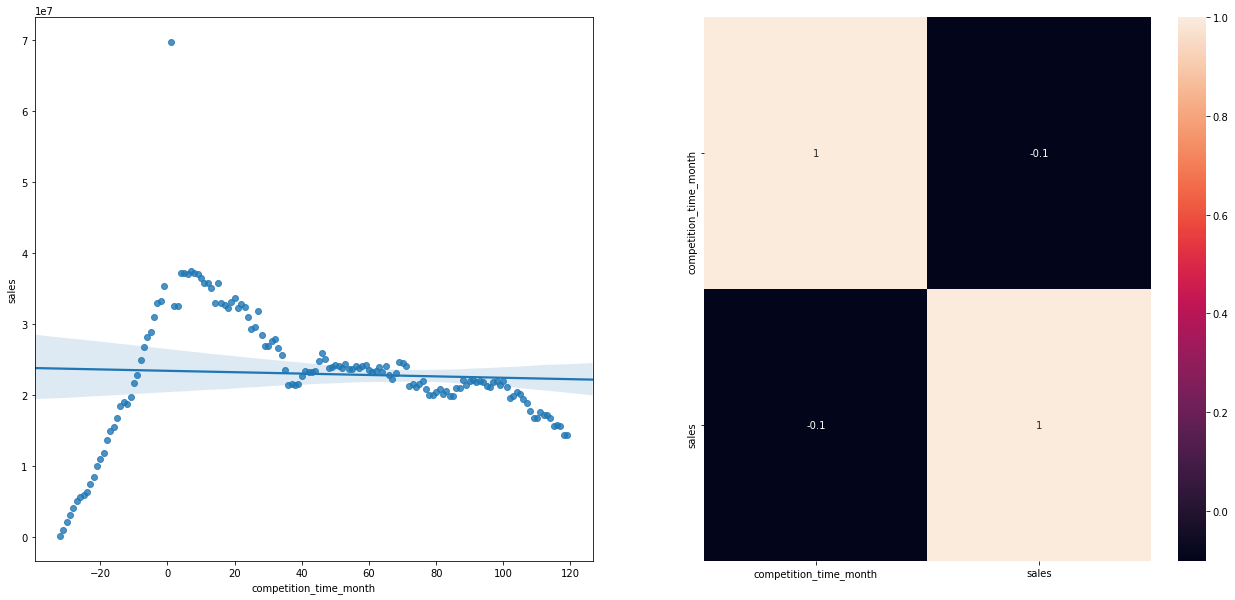

In [59]:
plt.subplot(1,2,1)
sns.regplot(x='competition_time_month', y = 'sales', data = aux2);

plt.subplot(1,2,2)
x = sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.

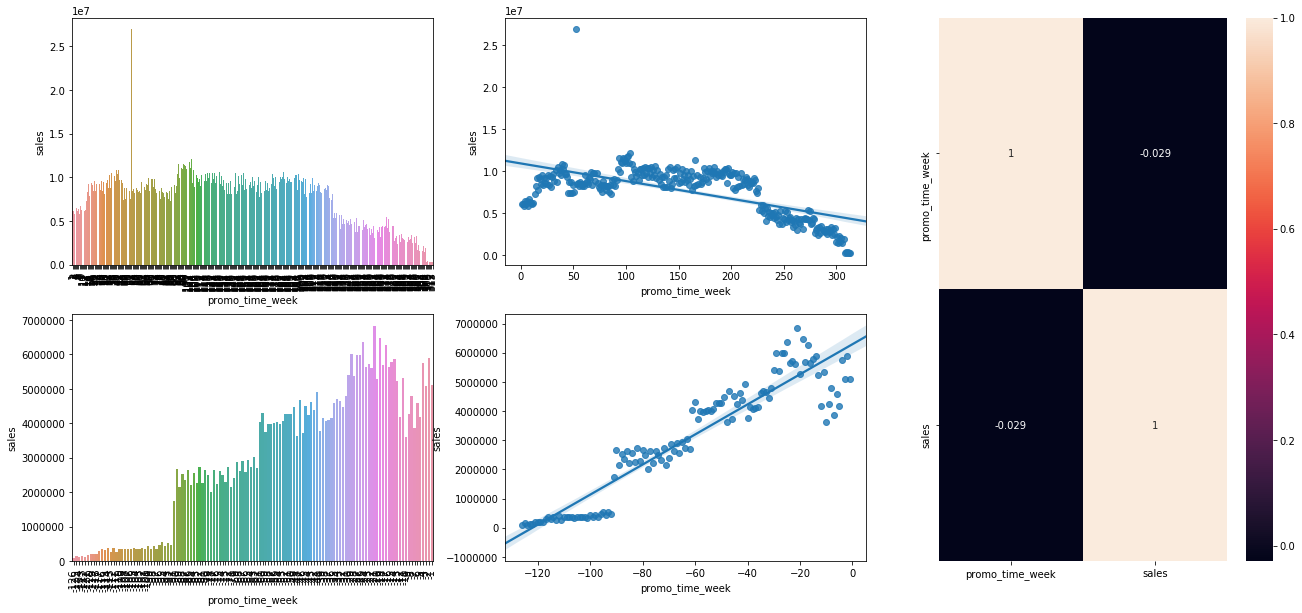

In [60]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

grid = gridspec.GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] #extended promo
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux2);
plt.xticks(rotation = 90);

plt.subplot(grid[0,1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] #regular promo
sns.barplot(x = 'promo_time_week', y = 'sales', data = aux3);
plt.xticks(rotation = 90);

plt.subplot(grid[1,1])
sns.regplot(x = 'promo_time_week', y = 'sales', data = aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot = True);

### <s>H5. Lojas com mais dias de promoção deveriam vender mais.</s>


### H6. Lojas com mais promoções consecutivas deveriam vender mais. 

***False***: Lojas com mais promos consecutivas vendem menos

In [42]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


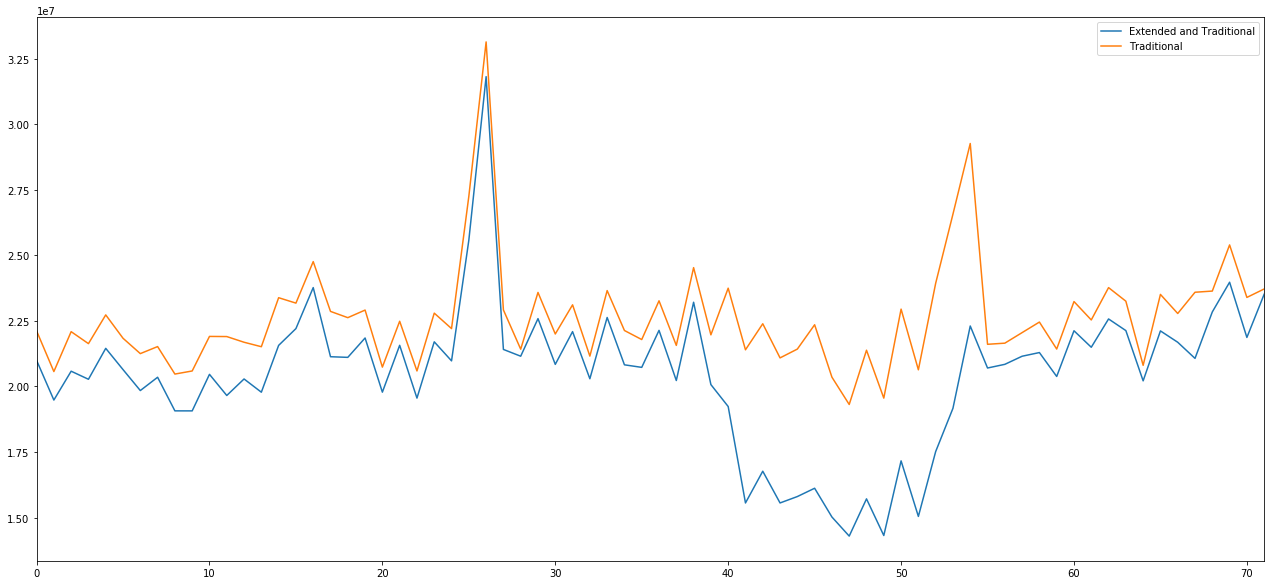

In [61]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1 )][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot()

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax)

ax.legend(labels = ['Extended and Traditional', 'Traditional']);

### H8. Lojas deveriam vender mais ao longo dos anos

***Falsa***: Lojas abertas durante o feriado do natal vendem menos

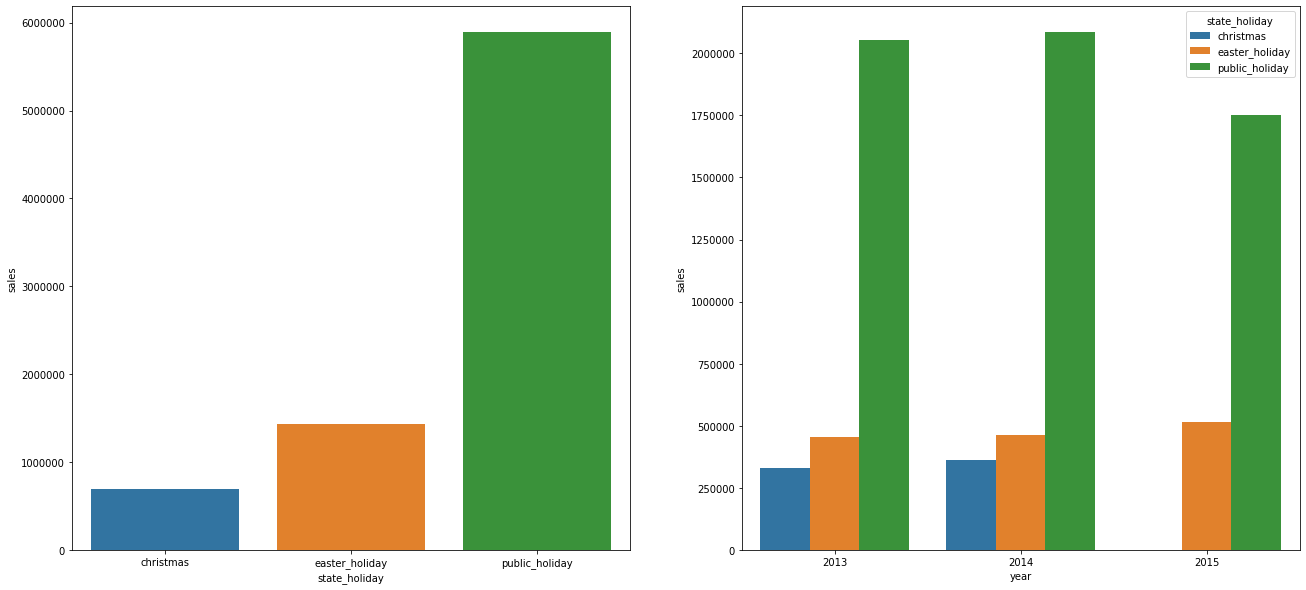

In [62]:
aux = df4[df4['state_holiday'] != 'regular_day']

plt.subplot(1,2,1)
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y = 'sales', data = aux1);

plt.subplot(1,2,2)
aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(x='year', y = 'sales', hue = 'state_holiday', data = aux2);

### H9. Lojas deveriam vender mais ao longo dos anos.

**False***: Lojas vendem menos ao longo dos anos

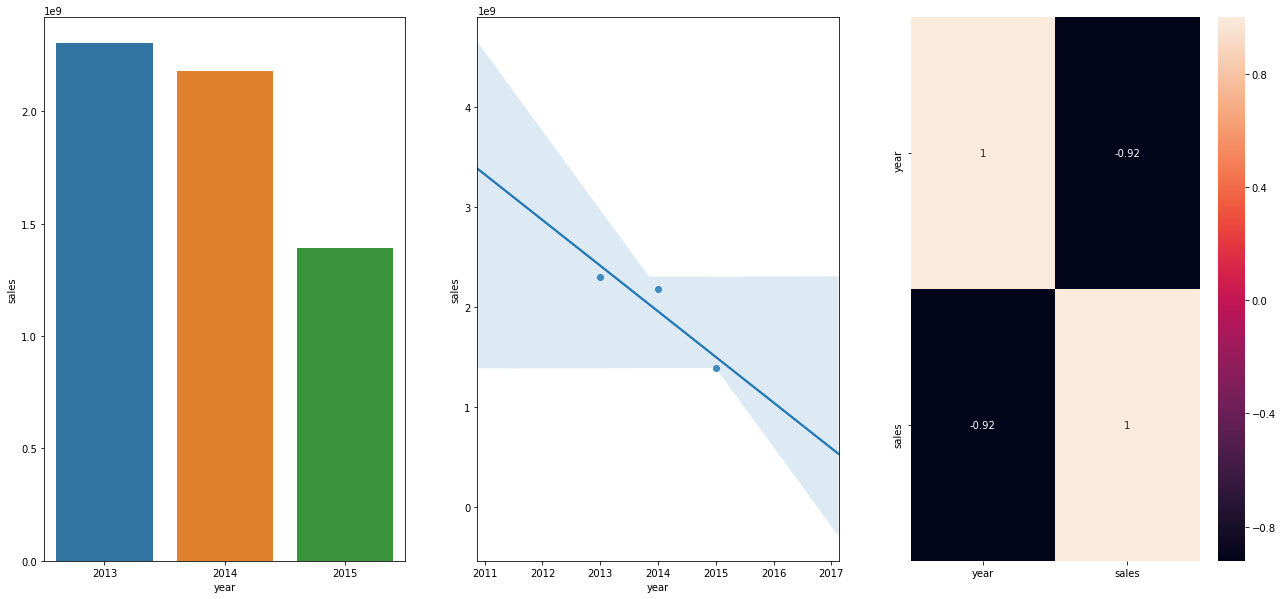

In [63]:
aux1 = df4[['year', 'sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'year', y = 'sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year', y = 'sales', data=aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### H10. Lojas deveriam vender mais no segundo semestre do ano.

***False***: Lojas vendem menos no segundo semestre|

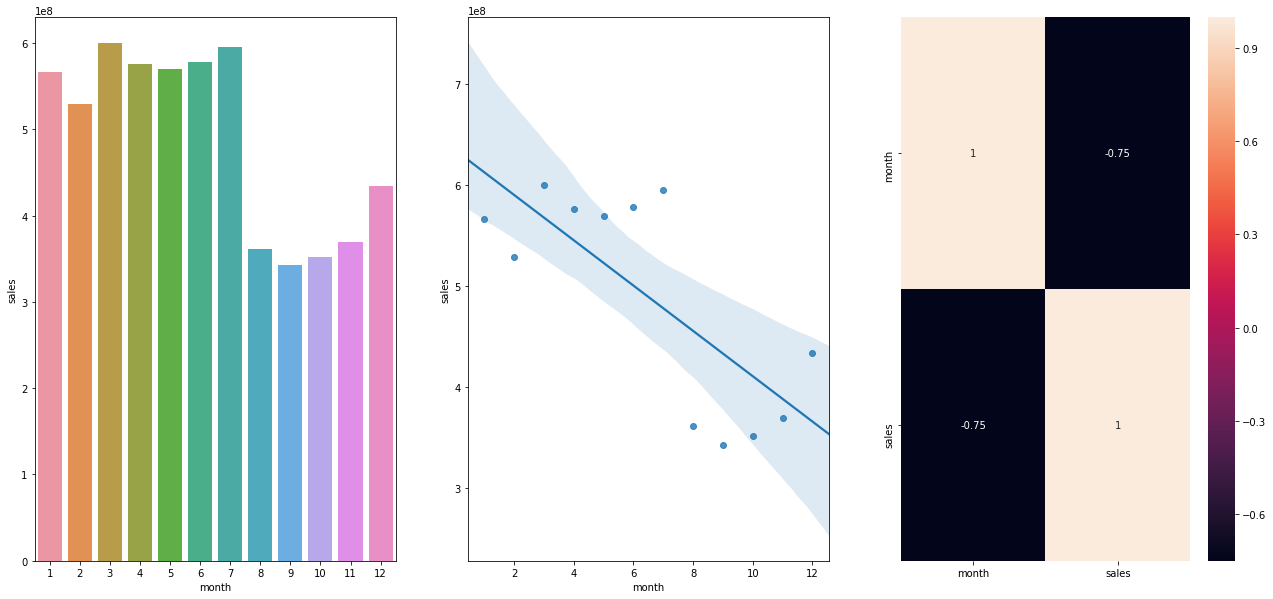

In [64]:
aux1 = df4[['month', 'sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x = 'month', y = 'sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='month', y = 'sales', data=aux1);


plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### H11. Lojas deveriam vender mais depois do dia 10 de cada mês.

**True**

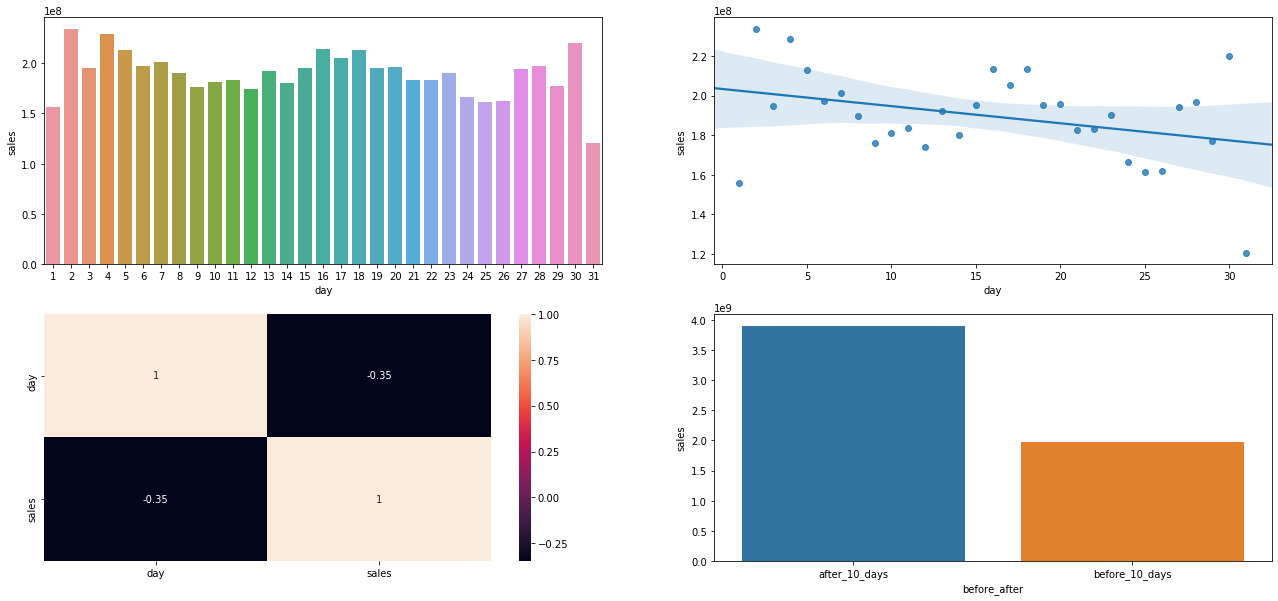

In [65]:
aux1 = df4[['day', 'sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x = 'day', y = 'sales', data=aux1);

plt.subplot(2,2,2)
sns.regplot(x='day', y = 'sales', data=aux1);


plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);


aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x<= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after', y = 'sales', data=aux2);

### H12. Lojas deveriam vender menos aos finais de semana.

***True***

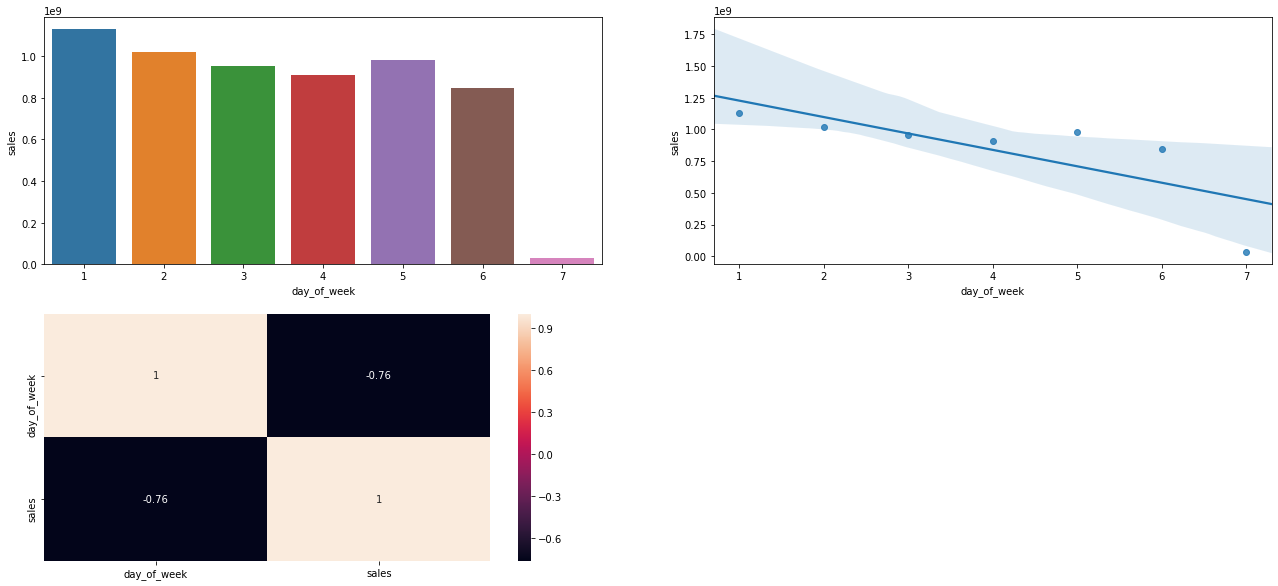

In [66]:
aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x = 'day_of_week', y = 'sales', data=aux1);

plt.subplot(2,2,2)
sns.regplot(x='day_of_week', y = 'sales', data=aux1);


plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method = 'pearson'), annot = True);

### H13. Lojas deveriam vender menos durante os feriados escolares.

**Verdadeira**: exceto mes de julho/agosto

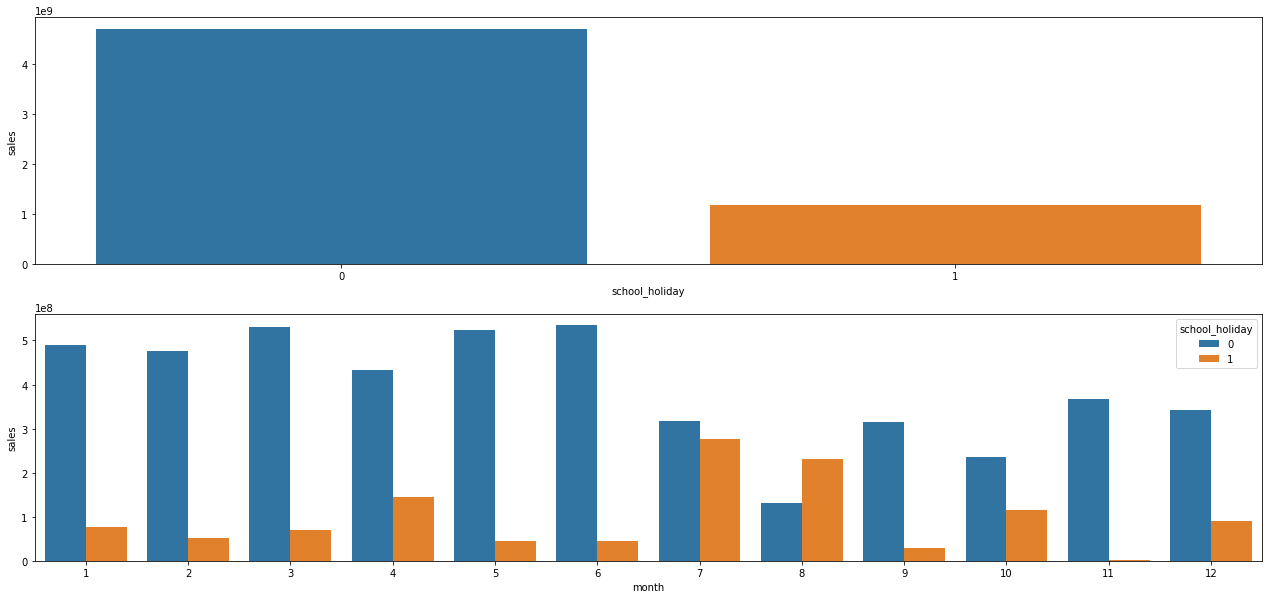

In [67]:
aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
plt.subplot(2,1,1)
sns.barplot(x = 'school_holiday', y = 'sales', data = aux1);

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
plt.subplot(2,1,2)
sns.barplot(x = 'month', y = 'sales', hue = 'school_holiday', data = aux2);

### 4.2.1. Hypothesis Summary

In [68]:
from tabulate import tabulate

In [69]:
tab = [['Hypotesis', 'Result', 'Relevance'],
      ['H1', 'False', 'Low'],
      ['H2', 'False', 'Average'],
      ['H3', 'False', 'Average'],
      ['H4', 'False', 'Low'],
      ['H5', '-', '-'],
      ['H7', 'False', 'Low'],
      ['H8', 'False', 'Average'],
      ['H9', 'False', 'High'],
      ['H10', 'False', 'High'],
      ['H11', 'True', 'High'],
      ['H12', 'True', 'High'],
      ['H13', 'True', 'High']]

print(tabulate(tab, headers = 'firstrow'))

Hypotesis    Result    Relevance
-----------  --------  -----------
H1           False     Low
H2           False     Average
H3           False     Average
H4           False     Low
H5           -         -
H7           False     Low
H8           False     Average
H9           False     High
H10          False     High
H11          True      High
H12          True      High
H13          True      High


## 4.3. Multivariated Analysis

#### 4.3.1. Numerical Attributes

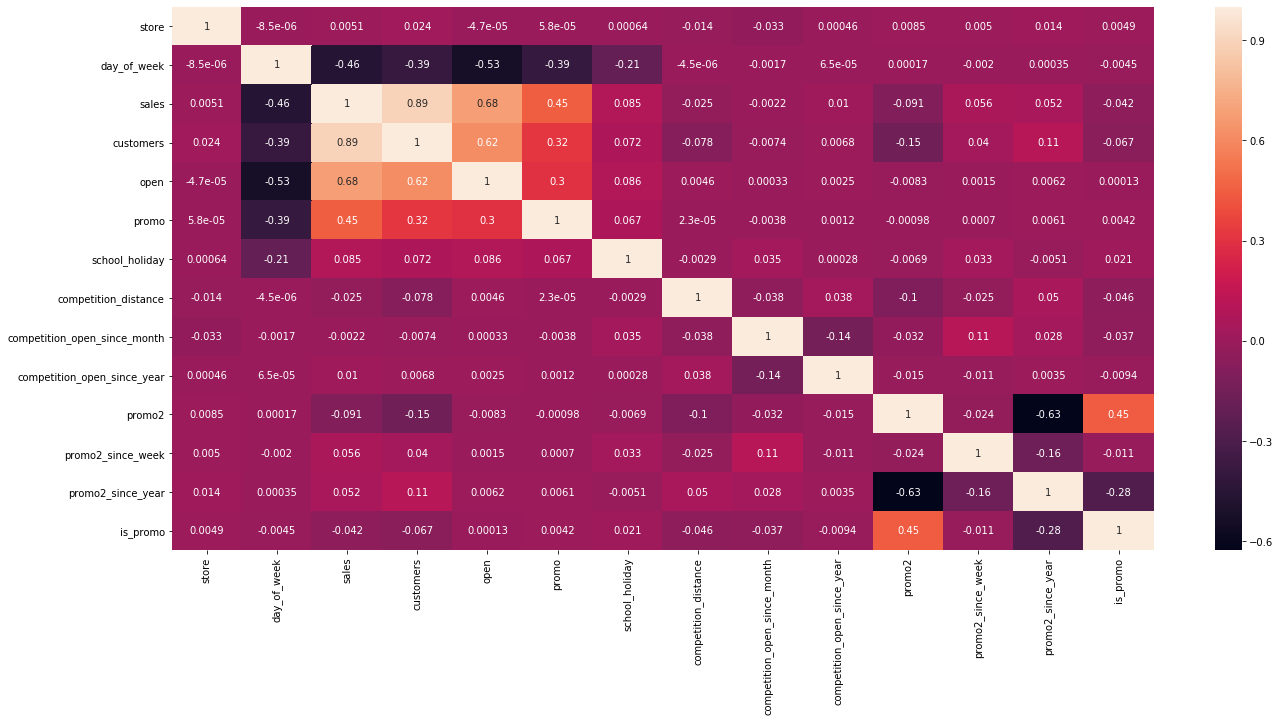

In [72]:
correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation, annot = True)

#### 4.3.2. Categorical Attributes

In [81]:
a = df4.select_dtypes(include = 'object')

a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

d = pd.DataFrame({'state_holiday': [a1, a2, a3],
                  'store_type': [a4, a5, a6],
                  'assortment': [a7,a8,a9] })

d = d.set_index(d.columns)

<ipython-input-77-5ac17fab40ae>:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  cm = pd.crosstab(x,y).as_matrix()


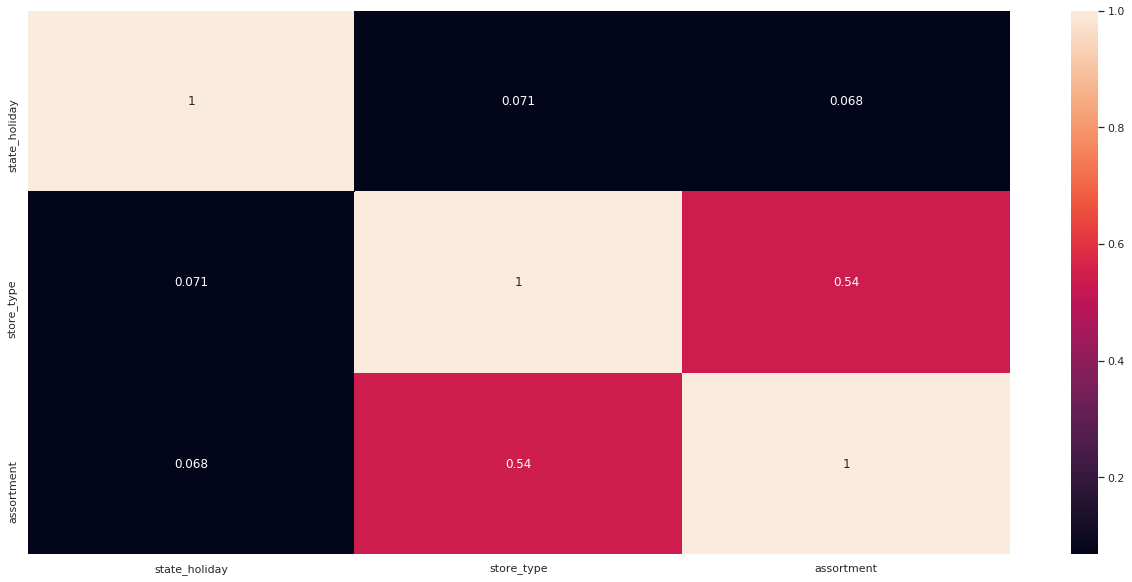

In [82]:
sns.heatmap(d, annot = True)

In [32]:
df4.to_csv('df_eda.csv', index = False, encoding ='utf-8')

# 5.0. Data Preparation

In [8]:
#df5 = df4.copy()
df5 = pd.read_csv('/home/joao/projetos/dsemprod/data_helpers/data_preparation.csv')

In [9]:
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 5.1. Normalization

## 5.2. Rescaling

In [10]:
a = df5.select_dtypes(include = ['int64', 'float64'])
a.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4,0


In [11]:
mms = MinMaxScaler()
rs = RobustScaler()


#competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('/home/joao/projetos/dsemprod/parameters/competition_distance_scaler.pkl', 'wb'))

#year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('/home/joao/projetos/dsemprod/parameters/year_scaler.pkl', 'wb'))

#competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('/home/joao/projetos/dsemprod/parameters/competition_time_month_scaler.pkl', 'wb'))

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(rs, open('/home/joao/projetos/dsemprod/parameters/promo_time_week_scaler.pkl', 'wb'))

## 5.3. Transformation

### 5.3.1 Encoding

In [71]:
#state holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns = ['state_holiday'])

#store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('/home/joao/projetos/dsemprod/parameters/store_type_scaler.pkl', 'wb'))

#assortment - Ordinal Encoding
assortment_dict = {'basic': 1, 
                   'extra': 2,
                   'extended': 3}

df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2. Response Variable

In [54]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3. Nature Transformation

In [55]:
#day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * ( 2* np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * ( 2* np.pi/7 ) ) )

#month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * ( 2* np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * ( 2* np.pi/12 ) ) )

#day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * ( 2* np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * ( 2* np.pi/30 ) ) )

#week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * ( 2* np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * ( 2* np.pi/52 ) ) )



In [56]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


In [57]:
df5.to_csv('data_eda.csv', index = False, encoding ='utf-8')

# 6.0. Feature Selection

In [29]:
#df6 = df5.copy()
df6 = pd.read_csv('/home/joao/projetos/dsemprod/data_helpers/feature_selection.csv')

## 6.1. Split dataframe into training and test dataset

In [30]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis = 1)

In [31]:
#df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days = 6*7)

#AJEITAR AS NOTAÇÕES DE X, Y, x, y - done

#training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

#training dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date: {}'.format( X_train['date'].min() ) )
print('Training Max Date:{}'.format( X_train['date'].max() ) )

print('\nTest Min Date: {}'.format( X_test['date'].min() ) )
print('Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01
Training Max Date:2015-06-18

Test Min Date: 2015-06-19
Test Max Date: 2015-07-31


## 6.2. Boruta as feature selection

In [29]:
#training and test dataset for Boruta
X_train_n = X_train.drop(['date', 'sales'], axis = 1).values
y_train_n = y_train.values.ravel()

#define RandomforestRegressor
rf = RandomForestRegressor(n_jobs = -1)

#define Boruta
boruta = BorutaPy( rf, n_estimators = 'auto', verbose = 2, random_state = 42 ).fit(X_train_n, Y_train_n)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	27
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	9


### 6.2.1. Best features from Boruta

In [33]:
cols_selected = boruta.support_.tolist()

#best features
X_train_fs = X_train.drop(['date', 'sales'], axis = 1)
cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

#not selected by boruta
cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

In [35]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_cos']

In [36]:
cols_not_selected_boruta

['is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_sin',
 'year']

## 6.3. Manual Feature Selection

In [32]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos']

#columns to add

feat_to_add = ['date', 'sales']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [24]:
cols_selected_boruta_full

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'date',
 'sales']

In [38]:
cols_selected_boruta

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos',
 'date',
 'sales']

# 7.0. Machine Learning Modeling

In [33]:
#apenas as variaveis relavantes pro modelo
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

#Time Series data prep. variaveis relevantes + date + sales
x_training = X_train[cols_selected_boruta_full].copy()
x_training['date'] = pd.to_datetime(x_training['date'])

## 7.1. Average Model

In [24]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns = {'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on = 'store')
yhat_baseline = aux1['predictions']

#performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline))

In [25]:
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 7.2. Linear Regression

In [72]:
#model
lr = LinearRegression().fit(x_train, y_train)

#prediction
yhat_lr = lr.predict(x_test)

#performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1870.022848,0.292413,2677.710622


### 7.2.1 Linear Regression - Cross Validation

In [89]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose = False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2080.25 +/- 293.21,0.3 +/- 0.02,2950.58 +/- 463.66


## 7.3. Linear Regression Regularized

In [90]:
#model
lrr = Lasso(alpha = 0.01).fit(x_train, y_train)

#prediction
yhat_lrr = lrr.predict(x_test)

#performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.571733,0.289606,2742.552397


### 7.3.1. Lasso - Cross Validation

In [91]:
lrr_result_cv = cross_validation(x_training, 5, 'Lasso', lrr, verbose = False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.87 +/- 342.08,0.29 +/- 0.01,3059.17 +/- 504.71


## 7.4. Random Forest Regressor

In [22]:
#model
rf = RandomForestRegressor(n_estimators = 100, n_jobs = -1, random_state = 42).fit(x_train, y_train)

#prediction
yhat_rf = rf.predict(x_test)

#performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,682.356315,0.100353,1018.646408


### 7.4.1. Random Forest Regressor - Cross Validation


In [12]:
rf = RandomForestRegressor(n_estimators = 100, n_jobs = -1, random_state = 42).fit(x_train, y_train)
rf_result_cv = cross_validation(X_training, 5, 'Random Forest Regressor', rf, verbose = True)
rf_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,841.92 +/- 208.25,0.12 +/- 0.02,1254.53 +/- 305.11


## 7.5 XGBoost

In [28]:


#model
model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror', n_estimators = 100,
                             eta = 0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9).fit(x_train, y_train)

#prediction
yhat_xgb = model_xgb.predict(x_test)

#performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

/home/joao/.pyenv/versions/3.8.10/envs/dsemproducao/lib/python3.8/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/joao/.pyenv/versions/3.8.10/envs/dsemproducao/lib/python3.8/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,902.294229,0.129007,1348.790584


### 7.5.1. XGBoost Regressor - Cross Validation

In [13]:
model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror', n_estimators = 100,
                             eta = 0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9).fit(x_train, y_train)

xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose = True )
xgb_result_cv

/home/joao/.pyenv/versions/3.8.10/envs/dsemproducao/lib/python3.8/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/joao/.pyenv/versions/3.8.10/envs/dsemproducao/lib/python3.8/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



KFold Number: 5

KFold Number: 4


/home/joao/.pyenv/versions/3.8.10/envs/dsemproducao/lib/python3.8/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/joao/.pyenv/versions/3.8.10/envs/dsemproducao/lib/python3.8/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



KFold Number: 3


/home/joao/.pyenv/versions/3.8.10/envs/dsemproducao/lib/python3.8/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/joao/.pyenv/versions/3.8.10/envs/dsemproducao/lib/python3.8/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



KFold Number: 2


/home/joao/.pyenv/versions/3.8.10/envs/dsemproducao/lib/python3.8/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/joao/.pyenv/versions/3.8.10/envs/dsemproducao/lib/python3.8/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \



KFold Number: 1


/home/joao/.pyenv/versions/3.8.10/envs/dsemproducao/lib/python3.8/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/joao/.pyenv/versions/3.8.10/envs/dsemproducao/lib/python3.8/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1025.68 +/- 159.57,0.14 +/- 0.01,1470.61 +/- 230.93


## 7.6. Compare Model's Performance

In [29]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
modelling_result.sort_values('RMSE')

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,682.356315,0.100353,1018.646408
0,XGBoost Regressor,902.294229,0.129007,1348.790584
0,Average Model,1354.800353,0.206400,1835.135542
0,Linear Regression,1870.022848,0.292413,2677.710622
0,Linear Regression - Lasso,1891.571733,0.289606,2742.552397


### 7.6.1. Real Performance - Cross Validation

In [ ]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result_cv.sort_values('RMSE')

# 8.0 Hyperparameter Fine Tuning

## 8.1. Random Search

In [9]:
import random
import warnings
warnings.filterwarnings('ignore')

In [17]:
param = {'n_estimators': [1500, 1700, 2500, 3000, 3500],
         'eta': [.01, .03], 
         'max_depth': [3, 5, 9],
         'subsample': [.1, .5, .7],
         'colsample_bytree': [.3, .7, .9],
         'min_child_weight': [3, 8, 15]}

MAX_EVAL = 5

In [ ]:
final_result = pd.DataFrame()

for i in range(MAX_EVAL):
    #CHOOSE VALUES FOR PARAMETERS RANDOMLY
    hp = {k: random.sample(v,1)[0] for k, v in param.items()}
    print(hp)
    
    
    #model
    model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror', n_estimators = hp['n_estimators'],
                                 eta = hp['eta'],
                                 max_depth=hp['max_depth'],
                                 subsample=hp['subsample'],
                                 colsample_bytree=hp['colsample_bytree'],
                                 min_child_weight = hp['min_child_weight'])


    #performance
    result = cross_validation(x_training, 2, 'XGBoost Regressor', model_xgb, verbose=True)
    final_result = pd.concat([final_result, result])

    print(final_result)

{'n_estimators': 1700, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 3}

KFold Number: 2

KFold Number: 1
          Model Name            MAE CV        MAPE CV             RMSE CV
0  XGBoost Regressor  875.95 +/- 85.81  0.12 +/- 0.01  1252.26 +/- 148.55
{'n_estimators': 2500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 8}

KFold Number: 2

KFold Number: 1
          Model Name            MAE CV        MAPE CV             RMSE CV
0  XGBoost Regressor  875.95 +/- 85.81  0.12 +/- 0.01  1252.26 +/- 148.55
0  XGBoost Regressor  865.21 +/- 97.07  0.12 +/- 0.01   1231.45 +/- 168.8
{'n_estimators': 1700, 'eta': 0.01, 'max_depth': 9, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 8}

KFold Number: 2


## 8.2. Final Model

In [10]:
param_tuned = {'n_estimators': 3000 ,
         'eta': .03, 
         'max_depth': 5,
         'subsample': 0.7,
         'colsample_bytree':0.7 ,
         'min_child_weight':3}


In [11]:
#model
model_xgb_tuned = xgb.XGBRegressor(objective = 'reg:squarederror', 
                                 n_estimators = param_tuned['n_estimators'],
                                 eta = param_tuned['eta'],
                                 max_depth=param_tuned['max_depth'],
                                 subsample=param_tuned['subsample'],
                                 colsample_bytree=param_tuned['colsample_bytree'],
                                 min_child_weight = param_tuned['min_child_weight']).fit(x_train, y_train)

#prediction

yhat_xgb_tuned = model_xgb_tuned.predict(x_test)
    
#performance

xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))

xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,672.01514,0.098625,968.17038


In [17]:
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))
mpe

0.0011629388520379208

In [13]:
#saves model
pickle.dump(model_xgb_tuned, open('/home/joao/projetos/dsemprod/projcode/model_rossman.pkl', 'wb'))

# 9.0 Error Interpretation

In [34]:
#RELOAD TRAINED MODEL
infile = open('/home/joao/projetos/dsemprod/projcode/parameters/model_rossman.pkl', 'rb')
model_xgb_tuned = pickle.load(infile)
infile.close()

In [35]:
yhat_xgb_tuned = model_xgb_tuned.predict(x_test) #makes prediction using test dataset
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,672.01514,0.098625,968.17038


In [36]:
df9 = X_test[cols_selected_boruta_full].copy()

#rescale 
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1. Business Performance

In [37]:
# sum of predictions
df9_1 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

#MAE and MAPE

df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns = {0: 'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns = {0: 'MAPE'})

#merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how = 'inner', on = 'store')
df9_2 = pd.merge(df9_1, df9_aux3, how='inner', on = 'store')



#scenario
df9_2['worst_scenario'] = df9_2['predictions'] - df9_2['MAE']
df9_2['best_scenario'] = df9_2['predictions'] + df9_2['MAE']

#order columns
df9_2 = df9_2[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]


In [38]:
df9_2.sort_values('MAPE', ascending = False).head(10)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,103980.695312,100683.869847,107277.520778,3296.825465,0.556093
908,909,234924.609375,227011.760318,242837.458432,7912.849057,0.537440
875,876,205741.734375,201868.868695,209614.600055,3872.865680,0.300632
721,722,346516.906250,344694.836505,348338.975995,1822.069745,0.244291
781,782,223221.156250,222395.770613,224046.541887,825.385637,0.243617
273,274,194757.703125,193367.628157,196147.778093,1390.074968,0.241516
1013,1014,428449.031250,426639.767341,430258.295159,1809.263909,0.231603
533,534,279895.843750,278504.428553,281287.258947,1391.415197,0.214946
840,841,111938.265625,111392.391737,112484.139513,545.873888,0.200229
562,563,183315.390625,182509.813457,184120.967793,805.577168,0.196960


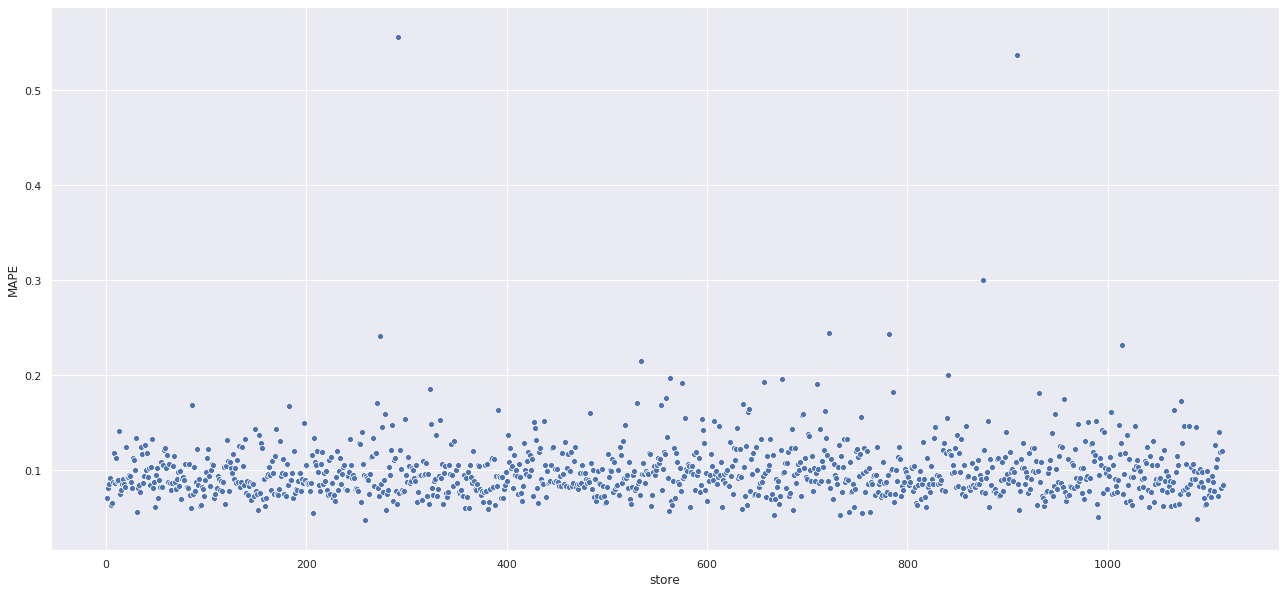

In [39]:
sns.scatterplot(x='store', y='MAPE', data = df9_2)

## 9.2. Total Performance

In [40]:
df9_3 = df9_2[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis = 0).reset_index().rename(columns={'index': 'Scenario', 0: 'Values'})
df9_3['Values'] = df9_3['Values'].map('R$ {:,.2f}'.format)
df9_3

,Scenario,Values
0,predictions,"R$ 284,415,287.52"
1,worst_scenario,"R$ 283,662,040.97"
2,best_scenario,"R$ 285,168,534.06"


## 9.3. Machine Learning Performance

In [50]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']
df9['date'] = pd.to_datetime(df9['date'])
df9.head()

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,competition_time_month,promo_time_week,day_of_week_sin,day_of_week_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,date,sales,predictions,error,error_rate
0,1,1,2,1,-0.170968,9,2008,0,31,2015,0.918919,0.287016,-0.974928,-0.222521,0.207912,0.978148,-0.568065,-0.822984,2015-07-31,5263.0,5003.630371,259.369629,0.950718
1,2,1,0,1,-0.283871,11,2007,1,13,2010,1.054054,0.922551,-0.974928,-0.222521,0.207912,0.978148,-0.568065,-0.822984,2015-07-31,6064.0,4838.633789,1225.366211,0.797928
2,3,1,0,1,1.903226,12,2006,1,14,2011,1.202703,0.801822,-0.974928,-0.222521,0.207912,0.978148,-0.568065,-0.822984,2015-07-31,8314.0,8522.236328,-208.236328,1.025046
3,4,1,2,3,-0.275806,9,2009,0,31,2015,0.743243,0.287016,-0.974928,-0.222521,0.207912,0.978148,-0.568065,-0.822984,2015-07-31,13995.0,10995.530273,2999.469727,0.785676
4,5,1,0,1,4.448387,4,2015,0,31,2015,-0.162162,0.287016,-0.974928,-0.222521,0.207912,0.978148,-0.568065,-0.822984,2015-07-31,4822.0,5825.877930,-1003.877930,1.208187


/home/joao/.pyenv/versions/3.8.10/envs/dsemproducao/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


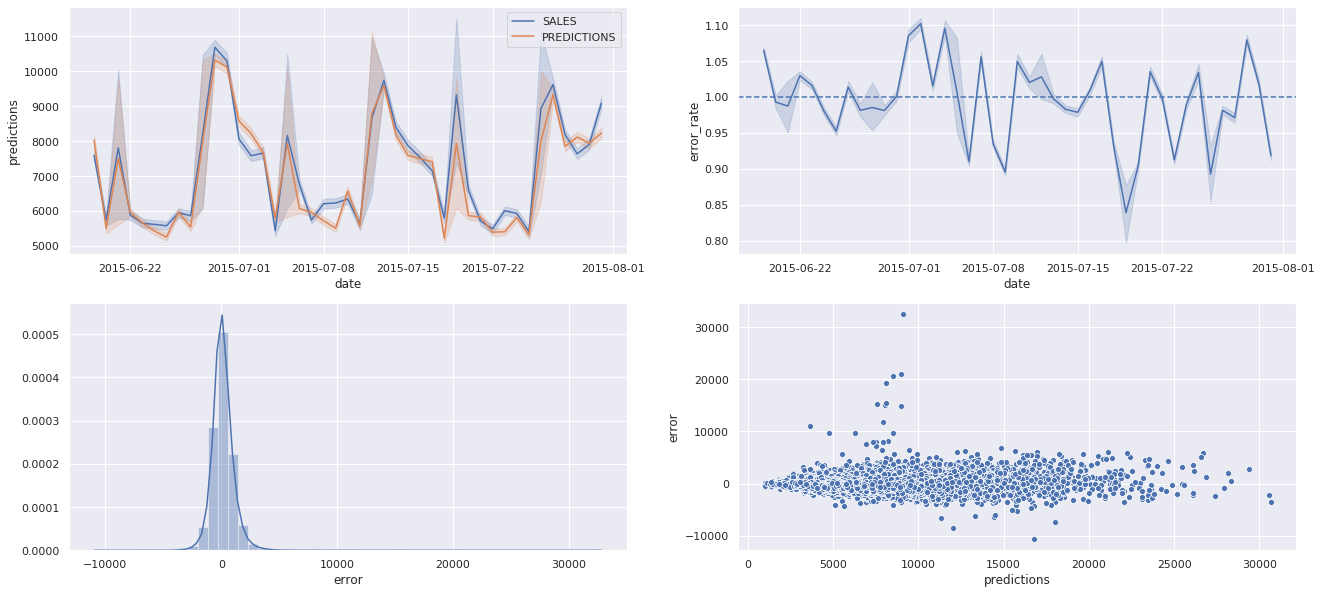

In [48]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )


plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline(1, linestyle='--')


plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] )

# 10. Model Deploy

## 10.1. Rossmann Class

In [ ]:
#RELOAD TRAINED MODEL
infile = open('/home/joao/projetos/dsemprod/projcode/model_rossman.pkl', 'rb')
model_xgb_tuned = pickle.load(infile)
infile.close()

In [12]:
class Rossmann(object):
    def __init__(self):
        self.competition_distance_scaler   = pickle.load(open('/home/joao/projetos/dsemprod/parameters/competition_distance_scaler.pkl', 'rb'))
        self.competition_time_month_scaler = pickle.load(open('/home/joao/projetos/dsemprod/parameters/competition_time_month_scaler.pkl', 'rb'))
        self.promo_time_week_scaler        = pickle.load(open('/home/joao/projetos/dsemprod/parameters/promo_time_week_scaler.pkl', 'rb'))
        self.year_scaler                   = pickle.load(open('/home/joao/projetos/dsemprod/parameters/year_scaler.pkl', 'rb'))
        self.store_type_scaler             = pickle.load(open('/home/joao/projetos/dsemprod/parameters/store_type.pkl', 'rb'))
        
        
    def data_cleaning(self, df1):
        

        ## 1.1. Rename Columns


        cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
           'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
           'CompetitionDistance', 'CompetitionOpenSinceMonth',
           'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
           'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore(x)

        cols_new = list(map(snakecase, cols_old))

        #rename
        df1.columns = cols_new


        ## 1.3. Data Types

        df1['date'] = pd.to_datetime(df1['date'])

        ## 1.5. Fillout NaN

        #competition_distance
        df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000 if math.isnan(x) else x)

        #competition_open_since_month
        df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis = 1)

        #competition_open_since_year    
        df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis = 1)

        #promo2_since_week
        df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis = 1)

        #promo2_since_year    
        df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis = 1)

        #promo_interval
        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7:'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

        df1['promo_interval'].fillna(0, inplace = True)
        df1['month_map'] = df1['date'].dt.month.map(month_map)

        #creating is_promo column which tells if a store is in the promo or not
        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis = 1)


        ## 1.6. Change Types
        
        #competition
        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
        
        #promo2
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
        
        return df1
    
    def feature_engineering(self, df2):
        #year
        df2['year'] = df2['date'].dt.year

        #month
        df2['month'] = df2['date'].dt.month

        #day
        df2['day'] = df2['date'].dt.day

        #week of the year
        df2['week_of_year'] = df2['date'].dt.weekofyear

        #year week format
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        #competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month = x['competition_open_since_month'], day = 1), axis = 1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

        #promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        
        #getting the data from the 1st day of the Wth week of the Yth year minus 7 days
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7))
        
        #subtracting the time of the sale and the data the promo started to extract the number of weeks the promo has been in progress
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

        #assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        #state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day') 
        
        # 3.0. Variable Filtering

        ## 3.1. Row Filtering

        #there are no sells when the store is closed, so we are excluding zero values 
        df2 = df2[(df2['open'] != 0) & (df2['sales'] > 0)]

        ## 3.2. Column Selection

        #the customers column is not accessible during the prediction time, so we've decided to exclude it
        #some other variables have been derivated in FE part or are not needed anymore, so we're deleting them now
        cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
        df2 = df2.drop(cols_drop, axis = 1)
    
        return df2
    
    def data_preparation(self, df5):

        #competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform(df5[['competition_distance']].values)

        #year
        df5['year'] = self.year_scaler.fit_transform(df5[['year']].values)

        #competition time month
        df5['competition_time_month'] = self.competition_time_month.fit_transform(df5[['competition_time_month']].values)
        

        # promo time week
        df5['promo_time_week'] = self.promo_type_week.fit_transform(df5[['promo_time_week']].values)
        

        ## 5.3. Transformation

        ### 5.3.1 Encoding

        #state holiday - One Hot Encoding
        df5 = pd.get_dummies(df5, prefix = ['state_holiday'], columns = ['state_holiday'])

        #store_type - Label Encoding

        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])

        #assortment - Ordinal Encoding
        assortment_dict = {'basic': 1, 
                           'extra': 2,
                           'extended': 3}

        df5['assortment'] = df5['assortment'].map(assortment_dict)


        ### 5.3.3. Nature Transformation

        #day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * ( 2* np.pi/7 ) ) )
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * ( 2* np.pi/7 ) ) )

        #month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * ( 2* np.pi/12 ) ) )
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * ( 2* np.pi/12 ) ) )

        #day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * ( 2* np.pi/30 ) ) )
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * ( 2* np.pi/30 ) ) )

        #week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * ( 2* np.pi/52 ) ) )
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * ( 2* np.pi/52 ) ) )
        
        cols_selected = [
                    'store',
                    'promo',
                    'store_type',
                    'assortment',
                    'competition_distance',
                    'competition_open_since_month',
                    'competition_open_since_year',
                    'promo2',
                    'promo2_since_week',
                    'promo2_since_year',
                    'competition_time_month',
                    'promo_time_week',
                    'day_of_week_sin',
                    'day_of_week_cos',
                    'day_sin',
                    'day_cos',
                    'week_of_year_sin',
                    'week_of_year_cos']
        
        return df5[cols_selected]


    
    

## 10.2. API Handler

In [ ]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

#loading model
model = picke.load(open('/home/joao/projetos/dsemprod/model/model_rossmann.pkl', 'rb'))


#initialize API
app = Flask(__name__)

@app.route('/rossmann/predict', methods =['POST'])
def rossmann_predict():
    test_json = request.get_json()
    
    if test_json: #there is data
        
        if isinstance(test_json, dict): #unique example
             test_raw = pd.DataFrame(test_json, index = [0]) 
        
        else: #Multiple examples
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
            
       #instantiate Rossmann class
        pipline = Rossmann()
        
       #data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        
        #feature engineering
        df2 = pipeline.feature_engineering(df1)
        
        #data preparation
        df3 = pipeline.data_preparation(df2)
        
        #prediction
        pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
        
    else:
        return Response('{}', status = 200, mimetype = 'application/json')
        
if __name__ == '__main__':
    app.run('0.0.0.0')
    

## 10.3. API Tester